In [3]:
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt
plt.style.use('custom_standard')
plt.style.use('custom_small')
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools

from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook I'm developing the sets of background frequencies to define. I'm also plotting some of that. I will then throw the code into `processing_scripts` and save the background frequencies in the `data/processed/` folder for use across the project.

make background distributions from:
- proteome
- nonbinders
- input library
- ilir background


# screening data

## proteome frequencies

In [4]:
def get_residue_frequencies(text):
    """Get the frequency of each residue in a sequence."""
    text = text.upper()
    # Remove non-standard residues
    text = ''.join([l for l in text if l in env.STANDARD_AMINO_ACIDS])
    count = {}
    for l in text:
        count.setdefault(l, 0)
        count[l] = count[l] + 1
    # Normalize the counts
    total = sum(count.values())
    for k in count:
        count[k] = count[k] / total
    return count

In [5]:
proteome_path = env.DATA_DIR / 'raw' / 'human_proteome_DB' / 'UP000005640_9606.fasta'
faimporter = seqtools.FastaImporter(proteome_path)
proteome = faimporter.import_as_list()
proteome_str = ''.join([str(s.seq) for s in proteome])

In [6]:
print(len(proteome_str))

11444946


In [7]:
proteome_bg = get_residue_frequencies(proteome_str)

## input library frequences

In [8]:
import lir_proteome_screen_pssm.sequence_utils as seqtools

df = pd.read_csv(env.RAWFILEPATHS.full_screening_table, sep='\t')
df = df[df['Input Count'] > 100]

In [9]:
screen_input_bg_str = ''.join(df['ID'].unique())

In [10]:
screen_input_bg = get_residue_frequencies(screen_input_bg_str)

In [11]:
print(len(screen_input_bg))

20


In [12]:
for k in proteome_bg.keys():
    print(k, proteome_bg[k]-screen_input_bg[k])

M -0.0010333621313775541
D 0.0034398001289835875
A 0.007577625098245798
S 0.00011217962398760162
P 0.007297670846054441
W -0.0014693710016022016
N -0.004423354158202976
T 0.0015513832702869629
V -0.0024249750281360796
L -0.0048013684059004386
I -0.009315102257340897
F -0.007682567345041642
G 0.007144397734520393
Y -0.003930979841897456
R 0.0007866315906893198
C -0.003367822460122672
Q 0.003952706264500096
K -0.0016102043317512207
E 0.008763647347578243
H -0.0005669349434732802


<Axes: xlabel='proteome', ylabel='Input Library'>

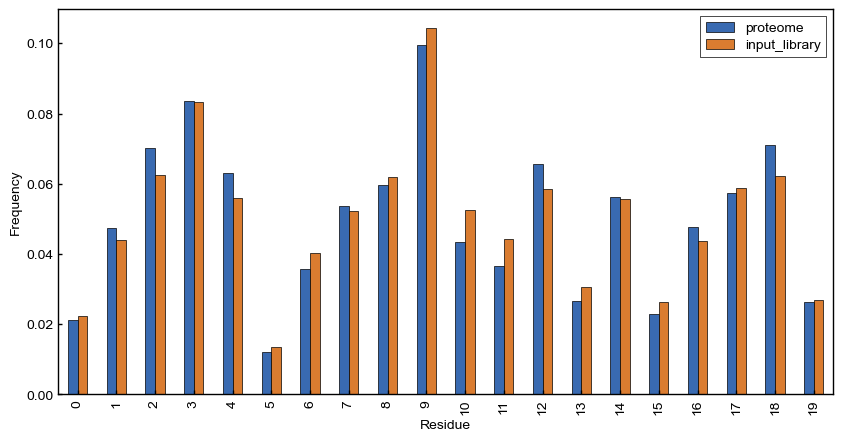

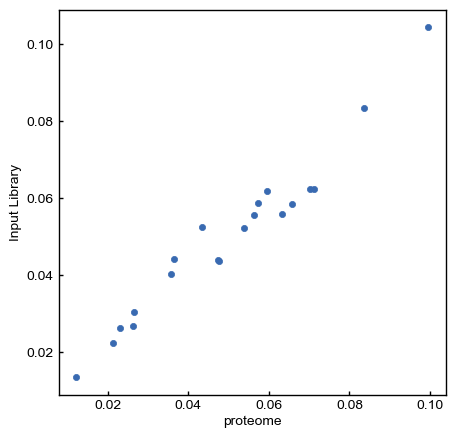

In [13]:
bg_freqs = pd.DataFrame.from_dict(proteome_bg, orient='index', columns=['proteome']).reset_index(names='Residue')
bg_freqs['input_library'] = bg_freqs['Residue'].map(screen_input_bg)
bg_freqs
bg_freqs.plot(kind='bar', figsize=(10, 5), xlabel='Residue', ylabel='Frequency')
bg_freqs.plot(x = "proteome", y = "input_library", kind='scatter', figsize=(5, 5), xlabel='proteome', ylabel='Input Library')

In [14]:
import pprint
pprint.pprint(bg_freqs[["input_library", "proteome"]].corr())

               input_library  proteome
input_library       1.000000  0.974301
proteome            0.974301  1.000000


plot library nonbinders and ilir background as well

## ilir background

<Axes: xlabel='proteome', ylabel='ilir background'>

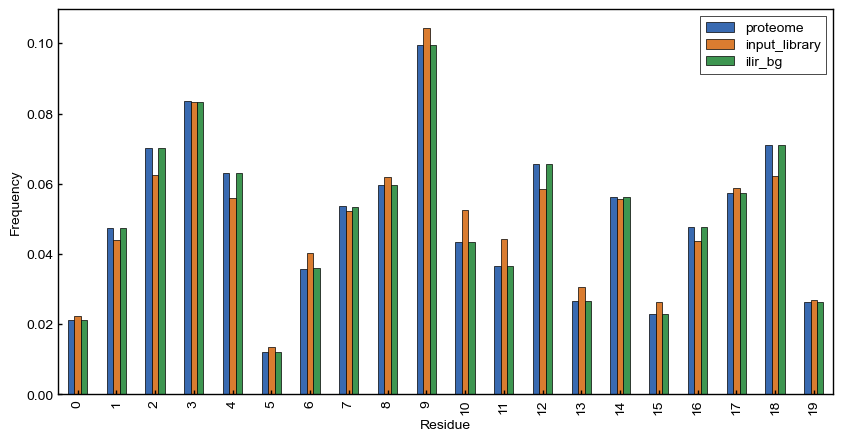

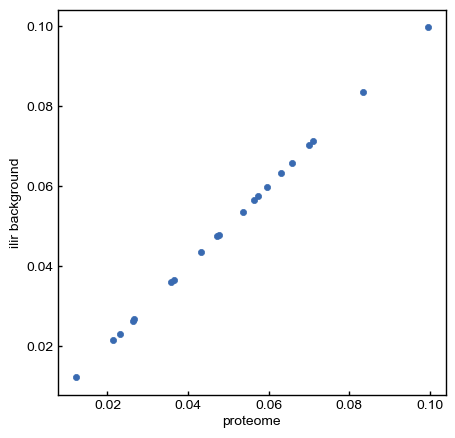

In [15]:
# from a previous notebook
ilir_bg = {
    'M': 0.02132438371877552,
    'L': 0.09963465604719016,
    'P': 0.06315319257172128,
    'K': 0.05732637839353644,
    'N': 0.03589313658554801,
    'R': 0.05636127568998062,
    'I': 0.04337783480203681,
    'A': 0.07013252855851457,
    'H': 0.026225904138650682,
    'E': 0.07103976737484315,
    'F': 0.03649449826285036,
    'G': 0.06574165474159767,
    'V': 0.05963890820620893,
    'D': 0.04737264484290967,
    'Q': 0.04769437510172419,
    'S': 0.08328850423348756,
    'C': 0.023007985040291584,
    'W': 0.012147453037774814,
    'Y': 0.026631039422129122,
    'T': 0.05351070860627121,
    'U': 3.170623957657374e-06
}
bg_freqs['ilir_bg'] = bg_freqs['Residue'].map(ilir_bg)
bg_freqs.plot(kind='bar', figsize=(10, 5), xlabel='Residue', ylabel='Frequency')
bg_freqs.plot(x = "proteome", y = "ilir_bg", kind='scatter', figsize=(5, 5), xlabel='proteome', ylabel='ilir background')

In [16]:
pprint.pprint(bg_freqs[["input_library", "proteome", "ilir_bg"]].corr())

               input_library  proteome   ilir_bg
input_library       1.000000  0.974301  0.974418
proteome            0.974301  1.000000  0.999992
ilir_bg             0.974418  0.999992  1.000000


## nonbinders from screen

<Axes: xlabel='proteome', ylabel='nonbinders undefined position frequency'>

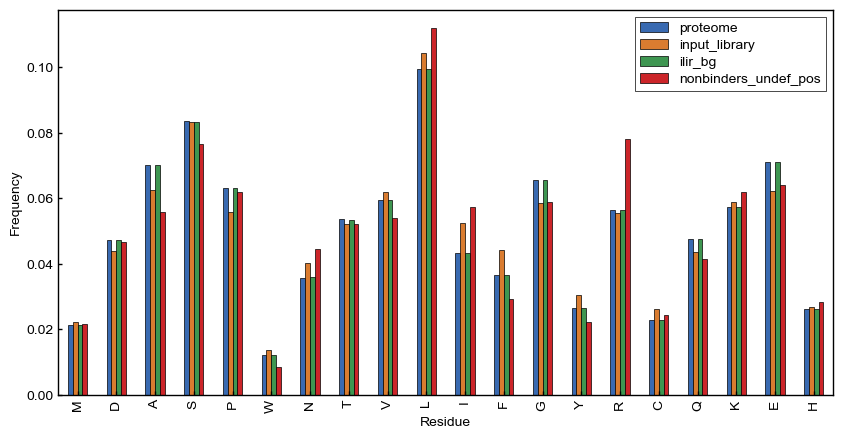

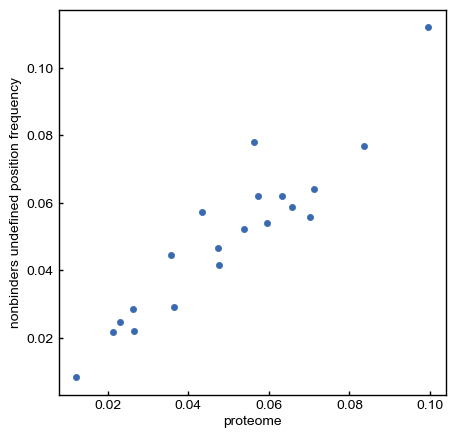

In [17]:
sc_df = pd.read_csv(env.RAWFILEPATHS.screening_hits_table)
nonbinders = sc_df[sc_df['Bind/Nonbind'] == 'Nonbind'].copy()
nonbinders = nonbinders['first_8_residues'].to_list()
c_nbs = pssms.alignment_2_counts(nonbinders) # residue counts
# take all the undefined positions from the non-binder set (all except 4 and 7)
undefined_positions = c_nbs.loc[[i for i in c_nbs.index if i != 4 and i!=7], :].copy()
# sum the counts for every residue and divide by the total number of counts
nonbinder_bg_frequency = (undefined_positions.sum()/undefined_positions.sum().sum())
bg_freqs['nonbinders_undef_pos'] = bg_freqs['Residue'].map(nonbinder_bg_frequency)
fig, ax = plt.subplots(figsize=(10, 5))
bg_freqs.plot(kind='bar', xlabel='Residue', ylabel='Frequency', ax=ax)
ax.set_xticks(range(len(bg_freqs)), labels=bg_freqs['Residue'])
bg_freqs.plot(x = "proteome", y = "nonbinders_undef_pos", kind='scatter', figsize=(5, 5), xlabel='proteome', ylabel='nonbinders undefined position frequency')

In [18]:
pprint.pprint(bg_freqs[["input_library", "proteome", "ilir_bg", "nonbinders_undef_pos"]].corr())

                      input_library  proteome   ilir_bg  nonbinders_undef_pos
input_library              1.000000  0.974301  0.974418              0.948729
proteome                   0.974301  1.000000  0.999992              0.932264
ilir_bg                    0.974418  0.999992  1.000000              0.932493
nonbinders_undef_pos       0.948729  0.932264  0.932493              1.000000


In [19]:
bg_freqs[["input_library", "proteome", "ilir_bg", "nonbinders_undef_pos"]].corr()

,input_library,proteome,ilir_bg,nonbinders_undef_pos
input_library,1.000000,0.974301,0.974418,0.948729
proteome,0.974301,1.000000,0.999992,0.932264
ilir_bg,0.974418,0.999992,1.000000,0.932493
nonbinders_undef_pos,0.948729,0.932264,0.932493,1.000000


### to me all of the backgrounds look very similar